# Estimating prediction sets on the Cifar10 dataset
The goal of this notebook is to present how to use :class:`mapie.classification.SplitConformalClassifier` on an object classification task. We will build prediction sets for images and study the marginal and conditional coverages.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scikit-learn-contrib/MAPIE/blob/master/notebooks/classification/Cifar10.ipynb)


### What is done in this tutorial ?

> - **Cifar10 dataset** : 10 classes (horse, dog, cat, frog, deer, bird, airplane, truck, ship, automobile)

> - Use :class:`mapie.classification.SplitConformalClassifier` to compare the prediction sets estimated by several conformal methods on the Cifar10 dataset.

> - Train a small CNN to predict the image class

> - Create a custom class `TensorflowToMapie` to resolve adherence problems between Tensorflow and Mapie



## Tutorial preparation

In [1]:
install_mapie = True
if install_mapie:
    !pip install mapie

pyenv: pip: command not found

The `pip' command exists in these Python versions:
  3.8.19

Note: See 'pyenv help global' for tips on allowing both
      python2 and python3 to be found.


In [4]:
import random
import warnings
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
from sklearn.metrics import accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

from mapie.metrics.classification import classification_coverage_score
from mapie.utils import train_conformalize_test_split
from mapie.classification import SplitConformalClassifier
from mapie.conformity_scores.sets import NaiveConformityScore

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %load_ext pycodestyle_magic

In [5]:
SPACE_BETWEEN_LABELS = 2.5
SPACE_IN_SUBPLOTS = 4.0
FONT_SIZE = 18


## 1. Data loading

The Cifar10 dataset is downloaded from the `Tensorflow Datasets` library. The training set is then splitted into a training, validation and a conformalization set which will be used as follow:

> - **Training set**: used to train our neural network.
> - **Validation set**: used to check that our model is not overfitting.
> - **Conformalization set**: used to conformalize the conformal scores in :class:`mapie.classification.SplitConformalClassifier`

In [6]:
def train_valid_conf_split(
    X: np.ndarray,
    y: np.ndarray,
    conf_size: float = .1,
    val_size: float = .3,
    random_state: int = 42

) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Create conformalization and validation datasets from the train dataset.

    Parameters
    ----------
    X: np.ndarray of shape (n_samples, width, height, n_channels)
        Images of the dataset.

    y: np.ndarray of shape (n_samples, 1):
        Label of each image.

    conf_size: float
        Percentage of the dataset X to use as conformalization set.

    val_size: float
        Percentage of the dataset X (minus the conformalization set)
        to use as validation set.

    random_state: int
        Random state to use to split the dataset.

        By default 42.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]
    of shapes:
    (n_samples * (1 - conf_size - val_size), width, height, n_channels),
    (n_samples * conf_size, width, height, n_channels),
    (n_samples * val_size, width, height, n_channels),
    (n_samples * (1 - conf_size - val_size), 1),
    (n_samples * conf_size, 1),
    (n_samples * val_size, 1).

    """
    (X_train, X_conf, X_val,
    y_train, y_conf, y_val) = train_conformalize_test_split(
        X, y, train_size=1-conf_size-val_size, conformalize_size=conf_size,
        test_size=val_size, random_state=random_state
        )
    return X_train, X_conf, X_val, y_train, y_conf, y_val


In [7]:
def load_data() -> Tuple[
    Tuple[np.ndarray, np.ndarray, np.ndarray],
    Tuple[np.ndarray, np.ndarray, np.ndarray],
    Tuple[np.ndarray, np.ndarray, np.ndarray],
    List
]:
    """
    Load cifar10 Dataset and return train, valid, conf, test datasets
    and the names of the labels


    Returns
    -------
    Tuple[
        Tuple[np.ndarray, np.ndarray, np.ndarray],
        Tuple[np.ndarray, np.ndarray, np.ndarray],
        Tuple[np.ndarray, np.ndarray, np.ndarray],
        List
    ]
    """
    dataset, info = tfds.load(
        "cifar10",
        batch_size=-1,
        as_supervised=True,
        with_info=True
    )
    label_names = info.features['label'].names

    dataset = tfds.as_numpy(dataset)
    X_train, y_train = dataset['train']
    X_test, y_test = dataset['test']
    X_train, X_conf, X_val, y_train, y_conf, y_val = train_valid_conf_split(
        X_train,
        y_train
    )

    X_train = X_train/255.
    X_val = X_val/255.

    X_conf = X_conf/255.
    X_test = X_test/255.

    y_train_cat = tf.keras.utils.to_categorical(y_train)
    y_val_cat = tf.keras.utils.to_categorical(y_val)
    y_conf_cat = tf.keras.utils.to_categorical(y_conf)
    y_test_cat = tf.keras.utils.to_categorical(y_test)

    train_set = (X_train, y_train, y_train_cat)
    val_set = (X_val, y_val, y_val_cat)
    conf_set = (X_conf, y_conf, y_conf_cat)
    test_set = (X_test, y_test, y_test_cat)

    return train_set, val_set, conf_set, test_set, label_names


In [8]:
def inspect_images(
    X: np.ndarray,
    y: np.ndarray,
    num_images: int,
    label_names: List
) -> None:
    """
    Load a sample of the images to check that images
    are well loaded.

    Parameters
    ----------
    X: np.ndarray of shape (n_samples, width, height, n_channels)
        Set of images from which the sample will be taken.

    y: np.ndarray of shape (n_samples, 1)
        Labels of the iamges of X.

    num_images: int
        Number of images to plot.

    label_names: List
        Names of the different labels

    """

    _, ax = plt.subplots(
        nrows=1,
        ncols=num_images,
        figsize=(2*num_images, 2)
    )

    indices = random.sample(range(len(X)), num_images)

    for i, indice in enumerate(indices):
        ax[i].imshow(X[indice])
        ax[i].set_title(label_names[y[indice]])
        ax[i].axis("off")
    plt.show()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/louislacombe/tensorflow_datasets/cifar10/incomplete.TGWQ6F_3.0.2/cifar10-train.tfrecord*...: …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/louislacombe/tensorflow_datasets/cifar10/incomplete.TGWQ6F_3.0.2/cifar10-test.tfrecord*...:  …

Dataset cifar10 downloaded and prepared to /Users/louislacombe/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


2025-11-05 17:36:58.289810: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


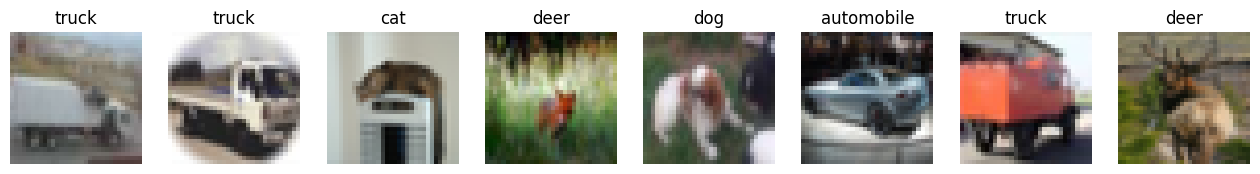

In [9]:
train_set, val_set, conf_set, test_set, label_names = load_data()
(X_train, y_train, y_train_cat) = train_set
(X_val, y_val, y_val_cat) = val_set
(X_conf, y_conf, y_conf_cat) = conf_set
(X_test, y_test, y_test_cat) = test_set
inspect_images(X=X_train, y=y_train, num_images=8, label_names=label_names)

## 2. Definition and training of the the neural network

We define a simple convolutional neural network with the following architecture :

> - 2 blocks of Convolution/Maxpooling
> - Flatten the images
> - 3 Dense layers
> - The output layer with 10 neurons, corresponding to our 10 classes

This simple architecture, based on the VGG16 architecture with its succession of convolutions and maxpooling aims at achieving a reasonable accuracy score and a fast training. The objective here is not to obtain a perfect classifier.


In [10]:
def get_model(
    input_shape: Tuple, loss: tfk.losses,
    optimizer: tfk.optimizers, metrics: List[str]
) -> Sequential:
    """
    Compile CNN model.

    Parameters
    ----------
    input_shape: Tuple
        Size of th input images.

    loss: tfk.losses
        Loss to use to train the model.

    optimizer: tfk.optimizer
        Optimizer to use to train the model.

    metrics: List[str]
        Metrics to use evaluate model training.

    Returns
    -------
    Sequential
    """
    model = Sequential([
        Conv2D(input_shape=input_shape, filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(input_shape=input_shape, filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(input_shape=input_shape, filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax'),
    ])
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## 3. Training the algorithm with a custom class called `TensorflowToMapie`

As MAPIE asks for a model with `fit`, `predict_proba`, `predict` class attributes and the information about whether or not the model is fitted.

In [11]:
class TensorflowToMapie():
    """
    Class that aims to make compatible a tensorflow model
    with MAPIE. To do so, this class create fit, predict,
    predict_proba and _sklearn_is_fitted_ attributes to the model.

    """

    def __init__(self) -> None:
        self.pred_proba = None
        self.trained_ = False


    def fit(
        self, model: Sequential,
        X_train: np.ndarray, y_train: np.ndarray,
        X_val: np.ndarray, y_val: np.ndarray
    ) -> None:
        """
        Train the keras model.

        Parameters
        ----------
        model: Sequential
            Model to train.

        X_train: np.ndarray of shape (n_sample_train, width, height, n_channels)
            Training images.

        y_train: np.ndarray of shape (n_samples_train, n_labels)
            Training labels.

        X_val: np.ndarray of shape (n_sample_val, width, height, n_channels)
            Validation images.

        y_val: np.ndarray of shape (n_samples_val, n_labels)
            Validation labels.

        """

        early_stopping_monitor = EarlyStopping(
                    monitor='val_loss',
                    min_delta=0,
                    patience=10,
                    verbose=0,
                    mode='auto',
                    baseline=None,
                    restore_best_weights=True
                    )
        model.fit(
                    X_train, y_train,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    epochs=20, callbacks=[early_stopping_monitor]
                )

        self.model = model
        self.trained_ = True
        self.classes_ = np.arange(model.layers[-1].units)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Returns the predicted probabilities of the images in X.

        Paramters:
        X: np.ndarray of shape (n_sample, width, height, n_channels)
            Images to predict.

        Returns:
        np.ndarray of shape (n_samples, n_labels)
        """
        preds = self.model.predict(X)

        return preds

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Give the label with the maximum softmax for each image.

        Parameters
        ---------
        X: np.ndarray of shape (n_sample, width, height, n_channels)
            Images to predict

        Returns:
        --------
        np.ndarray of shape (n_samples, 1)
        """
        pred_proba = self.predict_proba(X)
        pred = (pred_proba == pred_proba.max(axis=1)[:, None]).astype(int)
        return pred

    def __sklearn_is_fitted__(self):
        if self.trained_:
            return True
        else:
            return False

In [12]:
model = get_model(
    input_shape=(32, 32, 3),
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy']
)

In [13]:
cirfar10_model = TensorflowToMapie()
cirfar10_model.fit(model, X_train, y_train_cat, X_val, y_val_cat)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.3617 - loss: 1.7287 - val_accuracy: 0.4772 - val_loss: 1.4489
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5024 - loss: 1.3736 - val_accuracy: 0.5282 - val_loss: 1.3029
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5684 - loss: 1.1953 - val_accuracy: 0.5903 - val_loss: 1.1486
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6185 - loss: 1.0776 - val_accuracy: 0.6176 - val_loss: 1.0908
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6543 - loss: 0.9790 - val_accuracy: 0.6334 - val_loss: 1.0414
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6862 - loss: 0.8888 - val_accuracy: 0.6511 - val_loss: 0.9999
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7093 - loss: 0.8256 - val_accuracy: 0.6707 - val_loss: 0.9358
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7307 - loss: 0.7603 - val_accu

In [14]:
y_true = label_binarize(y=y_test, classes=np.arange(max(y_test)+1))
y_pred_proba = cirfar10_model.predict_proba(X_test)
y_pred = cirfar10_model.predict(X_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


## 4. Prediction of the prediction sets

We will now estimate the prediction sets with the five conformal methods implemented in :class:`mapie.classification.SplitConformalClassifier` for a range of confidence levels between 0 and 1.

In [15]:
method_params = {
    "naive": (NaiveConformityScore(), False),
    "lac": ("lac", False),
    "aps": ("aps", True),
    "random_aps": ("aps", "randomized"),
    "top_k": ("top_k", False)
}


In [16]:
y_preds, y_pss = {}, {}
confidence_levels = np.arange(0.01, 1, 0.01)

for name, (conformity_score, include_last_label) in method_params.items():
    mapie = SplitConformalClassifier(estimator=cirfar10_model, confidence_level=confidence_levels, conformity_score=conformity_score, prefit=True, random_state=42)
    mapie.conformalize(X_conf, y_conf)
    y_preds[name], y_pss[name] = mapie.predict_set(X_test, conformity_score_params={"include_last_label": include_last_label})

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Let's now estimate the number of null prediction sets, marginal coverages, and averaged prediction set sizes obtained with the different methods for all confidence levels and for a confidence level of 90 \%.

In [17]:
def count_null_set(y: np.ndarray) -> int:
    """
    Count the number of empty prediction sets.

    Parameters
    ----------
    y: np.ndarray of shape (n_sample, )

    Returns
    -------
    int
    """
    count = 0
    for pred in y[:, :]:
        if np.sum(pred) == 0:
            count += 1
    return count


In [20]:
nulls, coverages, accuracies, sizes = {}, {}, {}, {}
for name, (conformity_score, include_last_label) in method_params.items():
    accuracies[name] = accuracy_score(y_test, y_preds[name])
    nulls[name] = [
        count_null_set(y_pss[name][:, :, i]) for i, _ in enumerate(confidence_levels)
    ]
    coverages[name] = classification_coverage_score(y_test, y_pss[name])
    sizes[name] = [
        y_pss[name][:, :, i].sum(axis=1).mean() for i, _ in enumerate(confidence_levels)
    ]


In [21]:
coverage_90 = {conformity_score: coverage[90] for conformity_score, coverage in coverages.items()}
null_90 = {conformity_score: null[90] for conformity_score, null in nulls.items()}
width_90 = {conformity_score: width[90] for conformity_score, width in sizes.items()}
y_ps_90 = {conformity_score: y_ps[:, :, 90] for conformity_score, y_ps in y_pss.items()}

Let's now look at the marginal coverages, number of null prediction sets, and the averaged size of prediction sets for a confidence level of 90 \%.

In [22]:
summary_df = pd.concat(
    [
        pd.Series(coverage_90),
        pd.Series(null_90),
        pd.Series(width_90)
    ],
    axis=1,
    keys=["Coverages", "Number of null sets", "Average prediction set sizes"]
).round(3)

In [23]:
summary_df

,Coverages,Number of null sets,Average prediction set sizes
naive,0.910,0,2.307
lac,0.913,0,2.268
aps,0.943,0,2.841
random_aps,0.911,88,2.534
top_k,0.916,0,3.001


The table above shows that all the methods give a marginal coverage close to the desired one, i.e. 90\%. Notice that the "aps" method, which always includes the last label whose cumulated score is above the given quantile, tends to give slightly higher marginal coverages since the prediction sets are slightly too big. Besides, top-k score's tendency to build larger prediction sets compared to the other methods is highlighted here.

## 5. Visualization of the prediction sets

In [24]:
def prepare_plot(y_methods: Dict[str, Tuple], n_images: int) -> np.ndarray:
    """
    Prepare the number and the disposition of the plots according to
    the number of images.

    Paramters:
    y_methods: Dict[str, Tuple]
        Methods we want to compare.

    n_images: int
        Number of images to plot.

    Returns
    -------
    np.ndarray
    """
    plt.rcParams.update({'font.size': FONT_SIZE})
    nrow = len(y_methods.keys())
    ncol = n_images
    s = 5
    f, ax = plt.subplots(ncol, nrow, figsize=(s*nrow, s*ncol))
    f.tight_layout(pad=SPACE_IN_SUBPLOTS)
    rows = [i for i in y_methods.keys()]

    for x, row in zip(ax[:,0], rows):
        x.set_ylabel(row, rotation=90, size='large')

    return ax


In [25]:
def get_position(y_set: List, label: str, count: int, count_true: int) -> float:
    """
    Return the position of each label according to the number of labels to plot.

    Paramters
    ---------
    y_set: List
        Set of predicted labels for one image.

    label: str
        Indice of the true label.

    count: int
        Index of the label.

    count_true: int
        Total number of labels in the prediction set.

    Returns
    -------
    float
    """
    if y_set[label] :
        position = - (count_true - count)*SPACE_BETWEEN_LABELS

    else:
        position = - (count_true + 2 - count)*SPACE_BETWEEN_LABELS

    return position


def add_text(
    ax: np.ndarray, indices: Tuple, position: float,
    label_name: str, proba: float, color: str, missing: bool = False
) -> None:
    """
    Add the text to the corresponding image.

    Parameters
    ----------
    ax: np.ndarray
        Matrix of the images to plot.

    indices: Tuple
        Tuple indicating the indices of the image to put
        the text on.

    position: float
        Position of the text on the image.

    label_name: str
        Name of the label to plot.

    proba: float
        Proba associated to this label.

    color: str
        Color of the text.

    missing: bool
        Whether or not the true label is missing in the
        prediction set.

        By default False.

    """
    if not missing :
        text = f"{label_name} : {proba:.4f}"
    else:
        text = f"True label : {label_name} ({proba:.4f})"
    i, j = indices
    ax[i, j].text(
        15,
        position,
        text,
        ha="center", va="top",
        color=color
    )



In [26]:
def plot_prediction_sets(
    X: np.ndarray, y: np.ndarray,
    y_pred_proba: np.ndarray,
    y_methods: Dict[str, np.ndarray],
    n_images: int, label_names: Dict,
    random_state: Union[int, None] = None
) -> None:
    """
    Plot random images with their associated prediction
    set for all the required methods.

    Parameters
    ----------
    X: np.ndarray of shape (n_sample, width, height, n_channels)
        Array containing images.

    y: np.ndarray of shape (n_samples, )
        Labels of the images.

    y_pred_proba: np.ndarray of shape (n_samples, n_labels)
        Softmax output of the model.

    y_methods: Dict[str, np.ndarray]
        Outputs of the MapieClassifier with the different
        choosen methods.

    n_images: int
        Number of images to plot

    random_state: Union[int, None]
        Random state to use to choose the images.

        By default None.
    """
    random.seed(random_state)
    indices = random.sample(range(len(X)), n_images)

    y_true = y[indices]
    y_pred_proba = y_pred_proba[indices]
    ax = prepare_plot(y_methods, n_images)

    for i, method in enumerate(y_methods):
        y_sets = y_methods[method][indices]

        for j in range(n_images):
            y_set = y_sets[j]
            img, label= X[indices[j]], y_true[j]

            ax[i, j].imshow(img)

            count_true = np.sum(y_set)
            index_sorted_proba = np.argsort(-y_pred_proba[j])

            for count in range(count_true):
                index_pred = index_sorted_proba[count]
                proba = y_pred_proba[j][index_pred]
                label_name = label_names[index_pred]
                color = 'green' if index_pred == y_true[j] else 'red'
                position = get_position(y_set, label, count, count_true)

                add_text(ax, (i, j), position, label_name, proba, color)

            if not y_set[label] :
                label_name = label_names[label]
                proba = y_pred_proba[j][label]
                add_text(ax, (i, j), -3, label_name, proba, color= 'orange', missing=True)


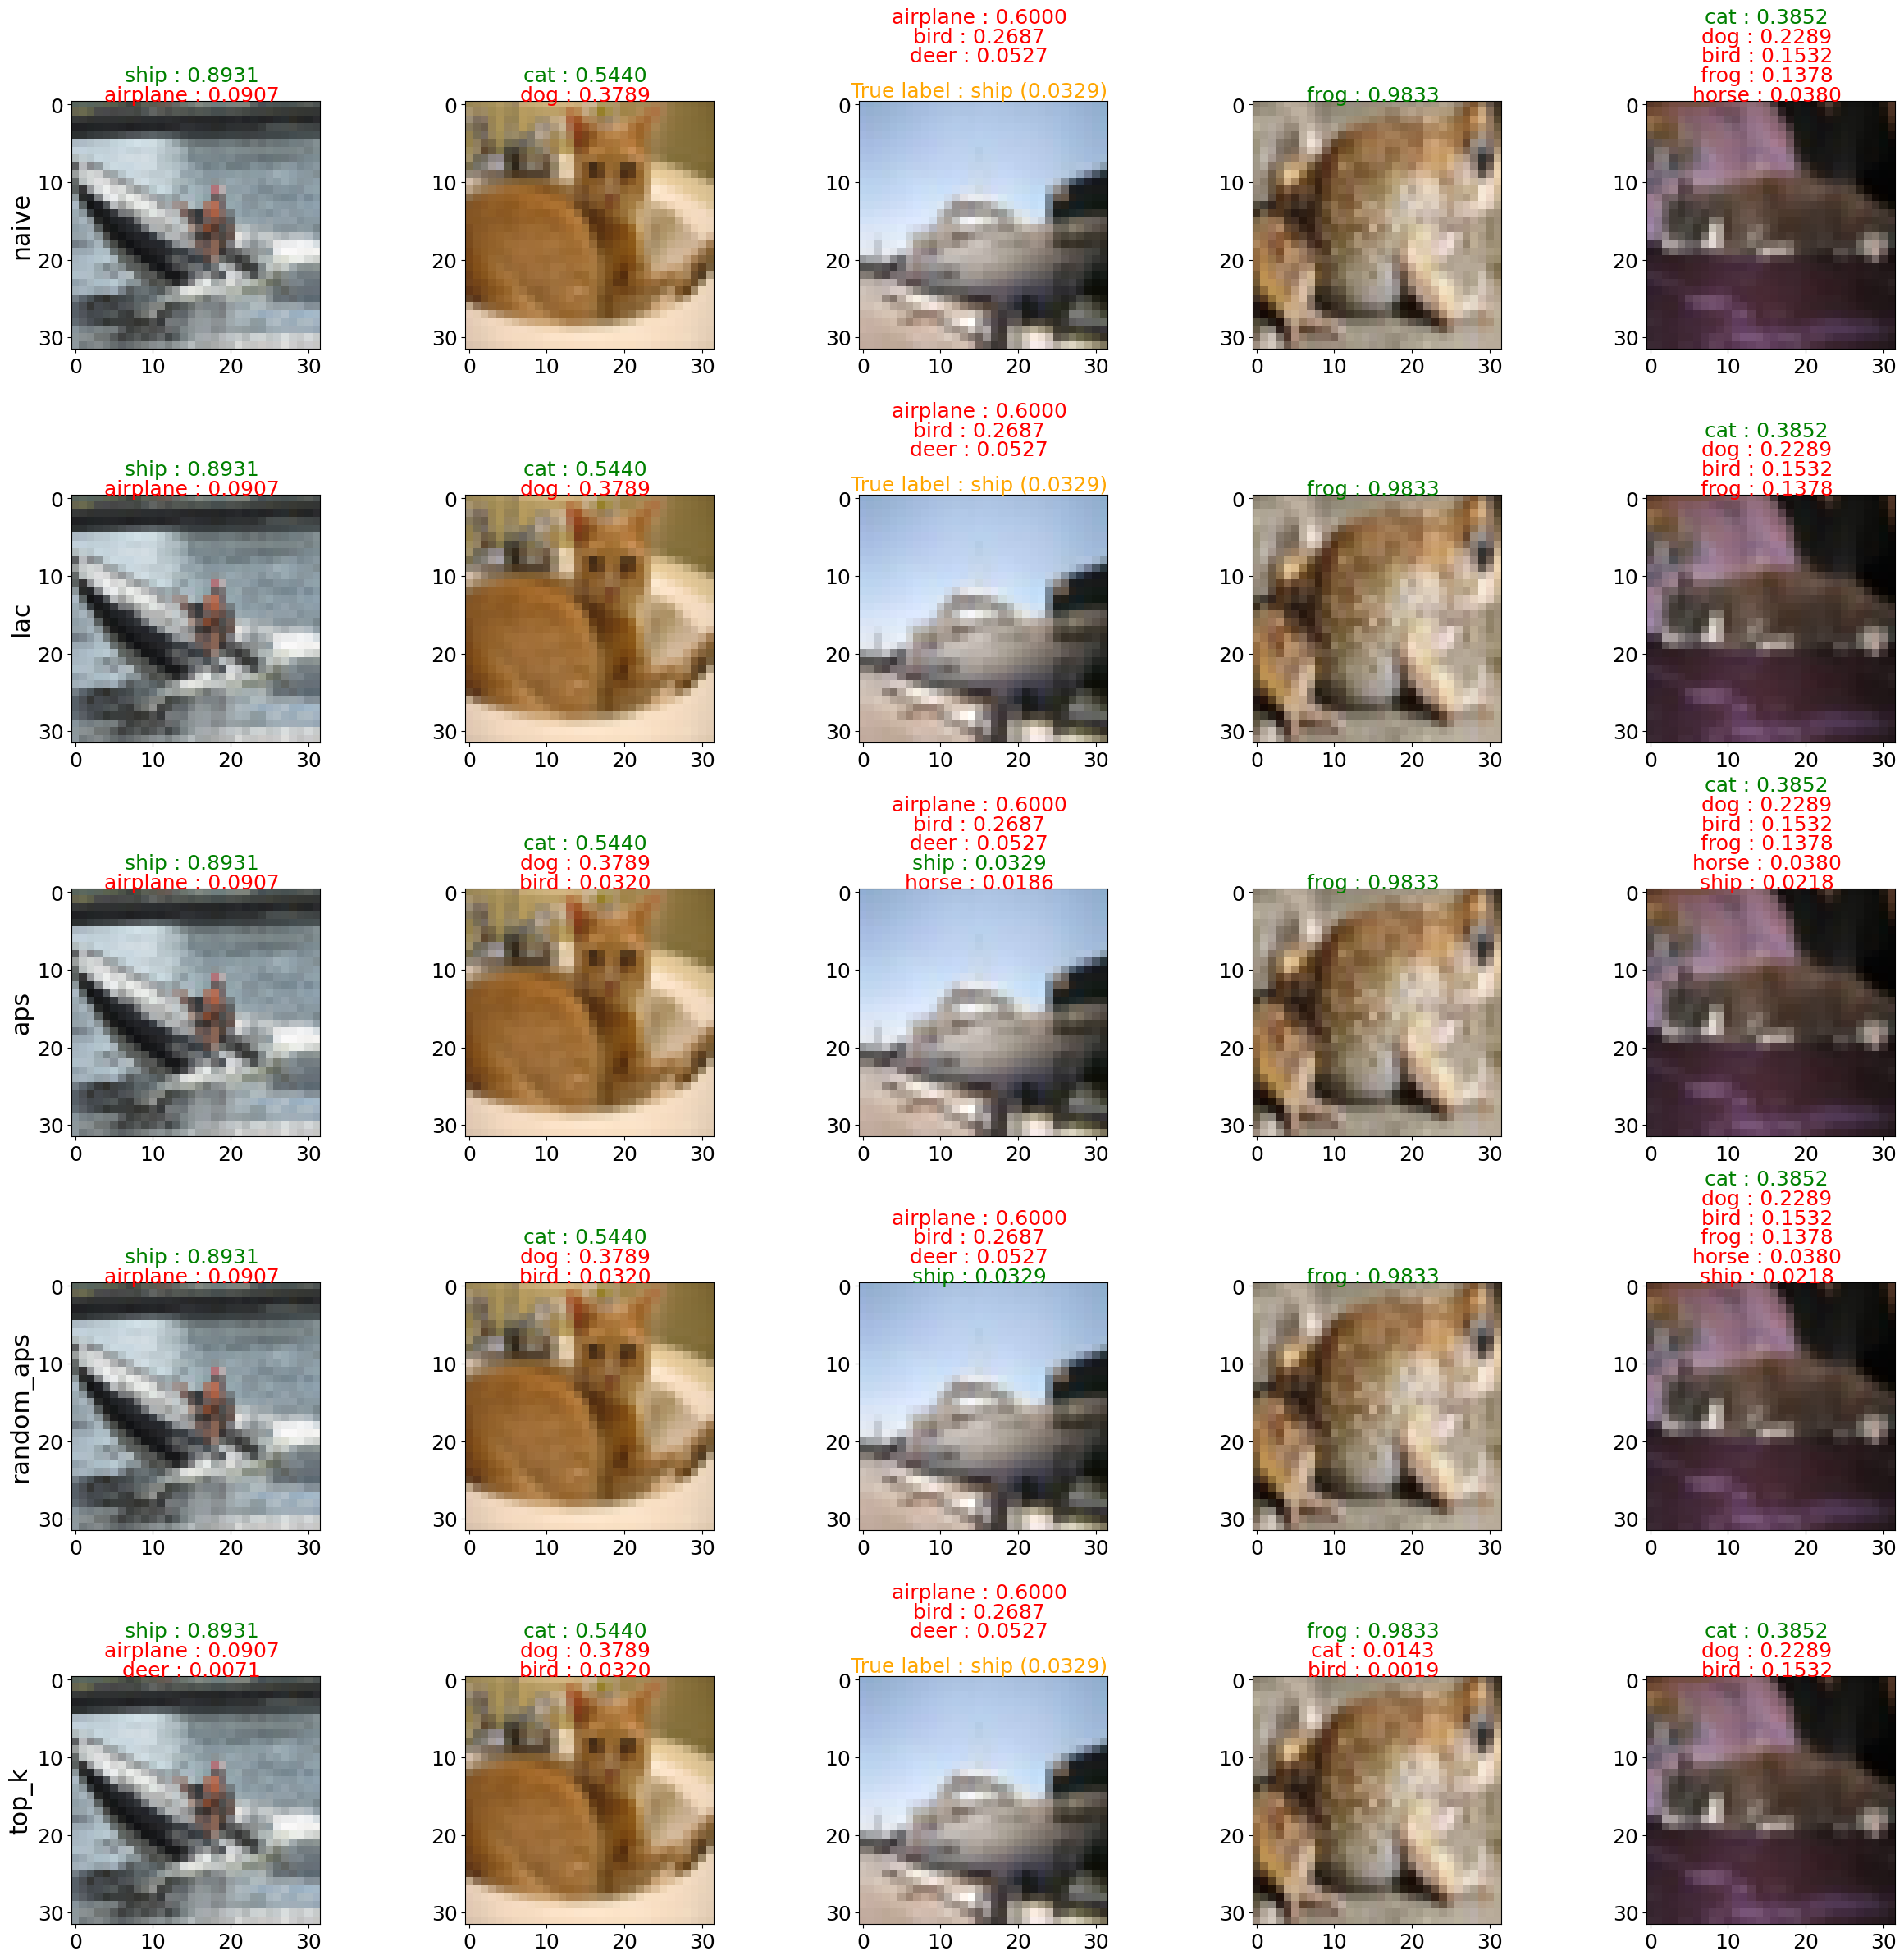

In [27]:
plot_prediction_sets(X_test, y_test, y_pred_proba, y_ps_90, 5, label_names)

## 6. Calibration of the methods

In this section, we plot the number of null sets, the marginal coverages, and the prediction set sizes as function of the target coverage level for all conformal methods.

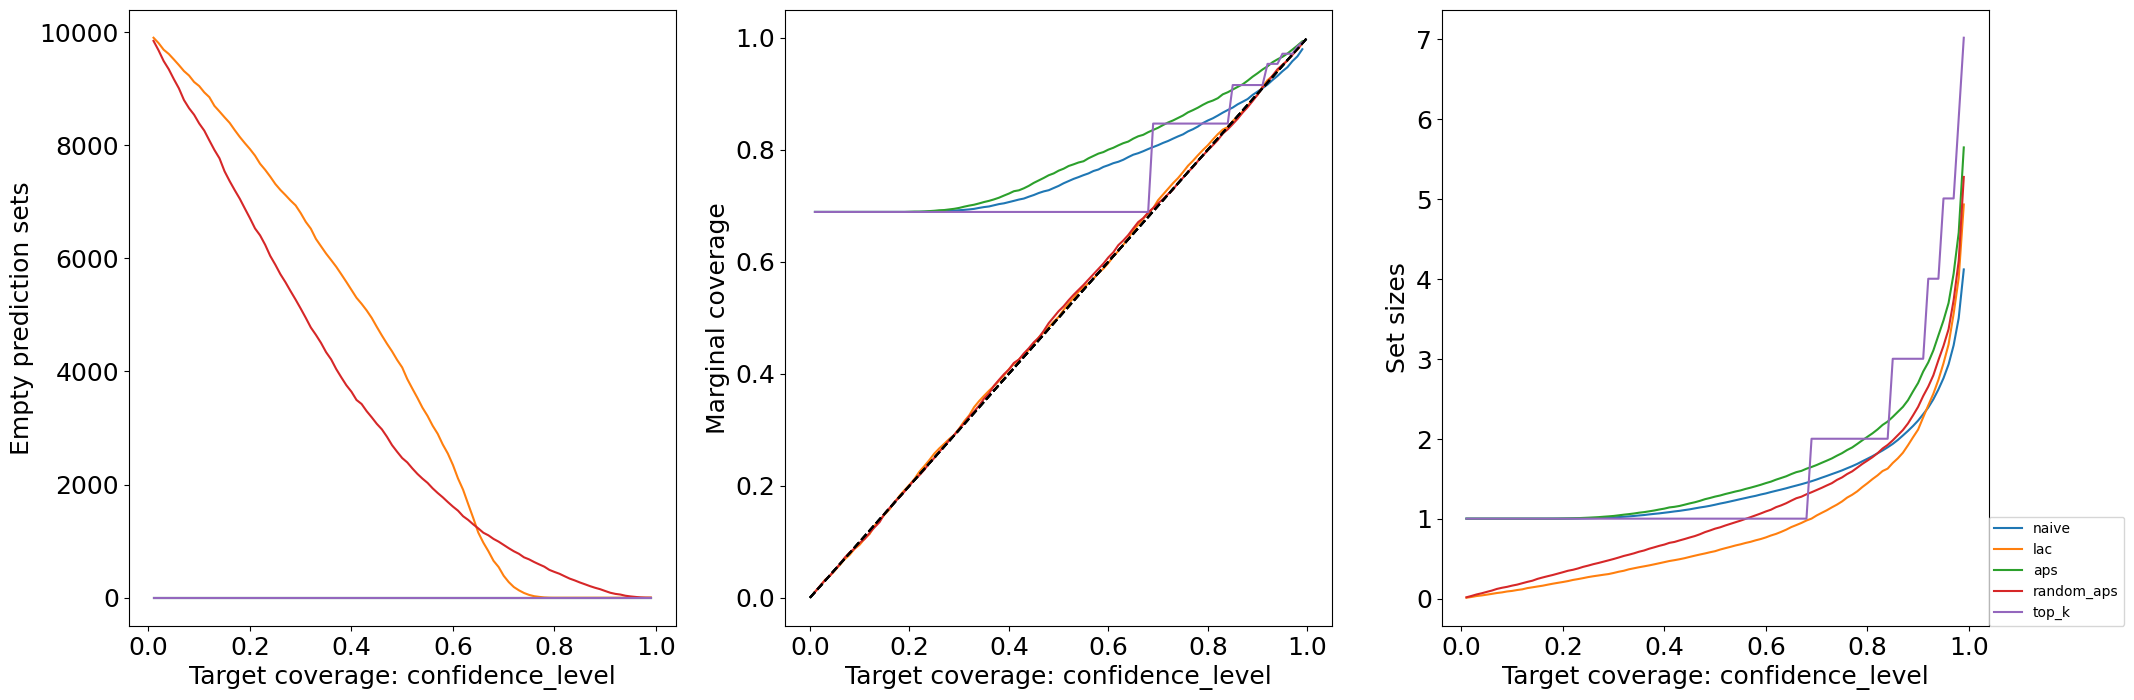

In [28]:
vars_y = [nulls, coverages, sizes]
labels_y = ["Empty prediction sets", "Marginal coverage", "Set sizes"]
fig, axs = plt.subplots(1, len(vars_y), figsize=(8*len(vars_y), 8))
for i, var in enumerate(vars_y):
    for name, (conformity_score, include_last_label) in method_params.items():
        axs[i].plot(confidence_levels, var[name], label=name)
        if i == 1:
            axs[i].plot([0, 1], [0, 1], ls="--", color="k")
    axs[i].set_xlabel("Target coverage: confidence_level")
    axs[i].set_ylabel(labels_y[i])
    if i == len(vars_y) - 1:
        axs[i].legend(fontsize=10, loc=[1, 0])

The two only methods which are perfectly calibrated for the entire range of confidence level values are the "lac" and "random_aps". However, these accurate marginal coverages can only be obtained thanks to the generation of null prediction sets. The compromise between estimating null prediction sets with conformalized coverages or non-empty prediction sets but with larger marginal coverages is entirely up to the user.

## 7. Prediction set sizes

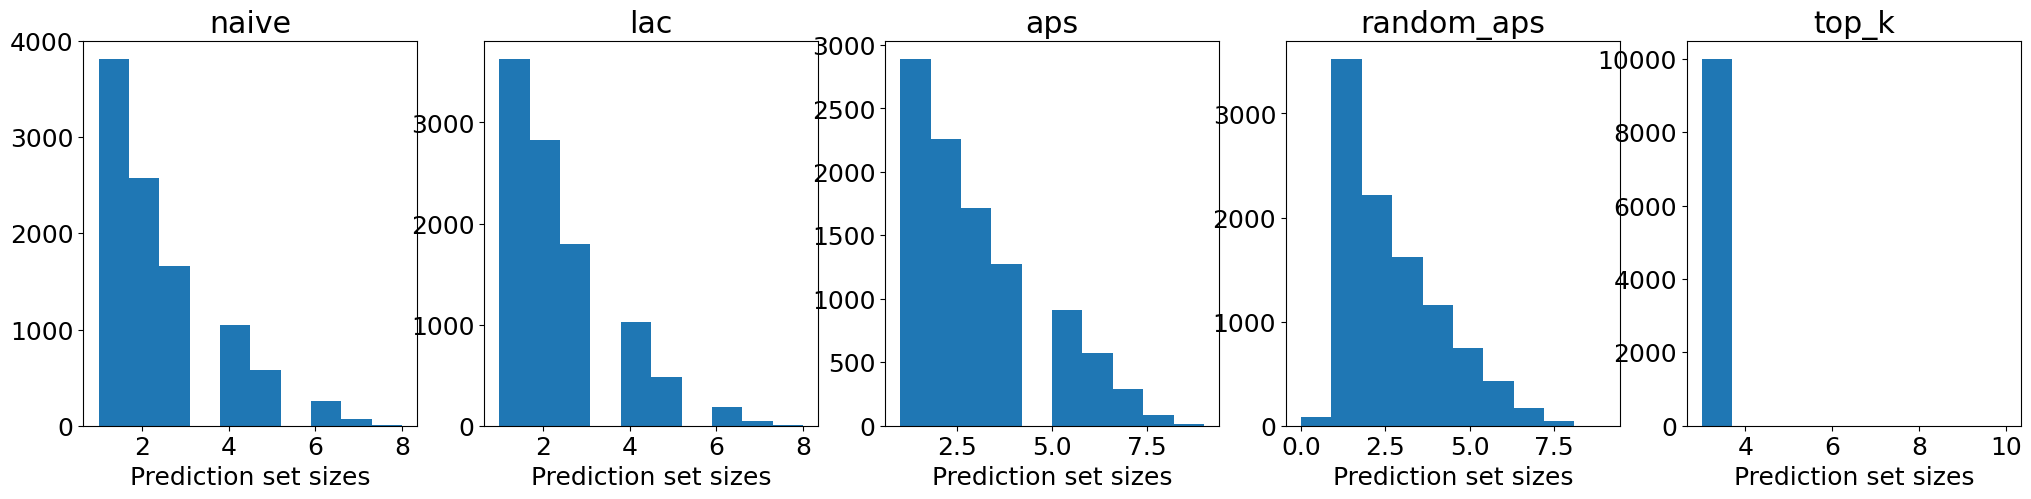

In [29]:
s=5
fig, axs = plt.subplots(1, len(y_preds), figsize=(s*len(y_preds), s))
for i, (method, y_ps) in enumerate(y_ps_90.items()):
    sizes = y_ps.sum(axis=1)
    axs[i].hist(sizes)
    axs[i].set_xlabel("Prediction set sizes")
    axs[i].set_title(method)

## 8. Conditional coverages

We just saw that all our methods give marginal coverages always larger than the target coverages for confidence level values ranging between 0 and 1. However, there is no mathematical guarantees on the *conditional* coverages, i.e. the coverage obtained for a specific class of images. Let's see what conditional coverages we obtain with the different conformal methods.

In [31]:
def get_class_coverage(
    y_test: np.ndarray,
    y_method: Dict[str, np.ndarray],
    label_names: List[str]
) -> None:
    """
    Compute the coverage for each class. As MAPIE is looking for a
    global coverage of confidence_level, it is important to check that their
    is not major coverage difference between classes.

    Parameters
    ----------
    y_test: np.ndarray of shape (n_samples,)
        Labels of the predictions.

    y_method: Dict[str, np.ndarray]
        Prediction sets for each method.

    label_names: List[str]
        Names of the labels.
    """
    recap ={}
    for method in y_method:
        recap[method] = []
        for label in sorted(np.unique(y_test)):
            indices = np.where(y_test==label)
            label_name = label_names[label]
            y_test_trunc = y_test[indices]
            y_set_trunc = y_method[method][indices]
            score_coverage = classification_coverage_score(y_test_trunc, y_set_trunc)[0]
            recap[method].append(score_coverage)
    recap_df = pd.DataFrame(recap, index = label_names)
    return recap_df


In [32]:
class_coverage = get_class_coverage(y_test, y_ps_90, label_names)

<Figure size 640x480 with 0 Axes>

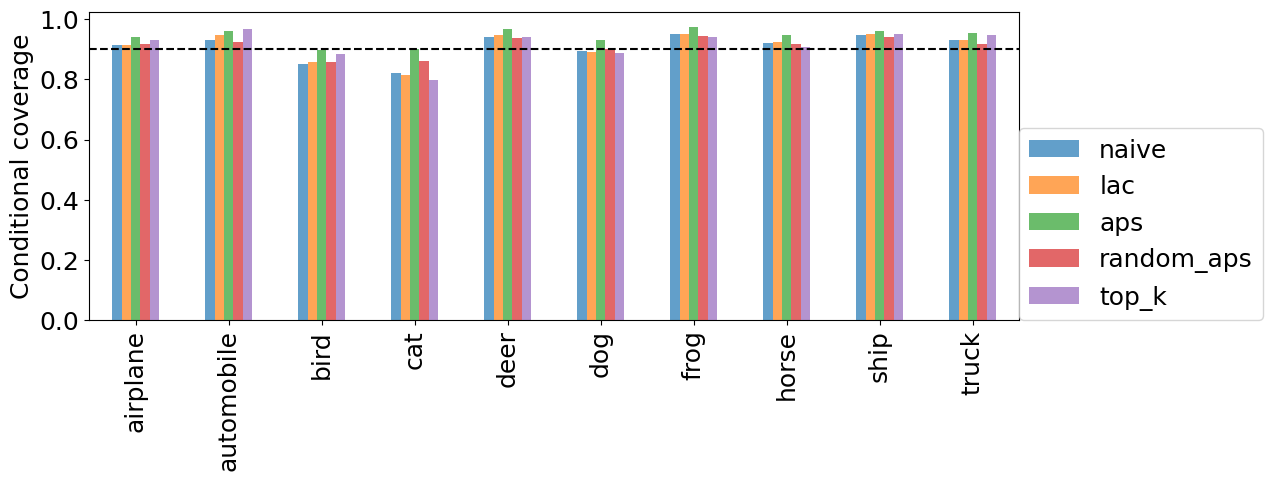

In [33]:
fig = plt.figure()
class_coverage.plot.bar(figsize=(12, 4), alpha=0.7)
plt.axhline(0.9, ls="--", color="k")
plt.ylabel("Conditional coverage")
plt.legend(loc=[1, 0])

We can notice that the conditional coverages slightly vary between classes. The only methods whose conditional coverages remain valid for all classes are the "aps" and "top_k" ones.

In [34]:
def create_confusion_matrix(y_ps: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    """
    Create a confusion matrix to visualize, for each class, which
    classes are which are the most present classes in the prediction
    sets.

    Parameters
    ----------
    y_ps: np.ndarray of shape (n_samples, n_labels)
        Prediction sets of a specific method.

    y_true: np.ndarray of shape (n_samples, )
        Labels of the sample

    Returns
    -------
    np.ndarray of shape (n_labels, n_labels)
    """
    number_of_classes = len(np.unique(y_true))
    confusion_matrix = np.zeros((number_of_classes, number_of_classes))
    for i, ps in enumerate(y_ps):
        confusion_matrix[y_true[i]] += ps

    return confusion_matrix


In [35]:
def reorder_labels(ordered_labels: List, labels: List, cm: np.ndarray) -> np.ndarray:
    """
    Used to order the labels in the confusion matrix

    Parameters
    ----------
    ordered_labels: List
        Order you want to have in your confusion matrix

    labels: List
        Initial order of the confusion matrix

    cm: np.ndarray of shape (n_labels, n_labels)
        Original confusion matrix

    Returns
    -------
    np.ndarray of shape (n_labels, n_labels)
    """
    cm_ordered = np.zeros(cm.shape)
    index_order = [labels.index(label) for label in ordered_labels]
    for i, label in enumerate(ordered_labels):
        old_index = labels.index(label)

        cm_ordered[i] = cm[old_index, index_order]
    return cm_ordered

In [36]:
def plot_confusion_matrix(method: str, y_ps: Dict[str, np.ndarray], label_names: List) -> None:
    """
    Plot the confusion matrix for a specific method.

    Parameters
    ----------
    method: str
        Name of the method to plot.

    y_ps: Dict[str, np.ndarray]
        Prediction sets for each of the fitted method

    label_names: List
        Name of the labels
    """

    y_method = y_ps[method]
    cm = create_confusion_matrix(y_method, y_test)
    ordered_labels = ["frog", "cat", "dog", "deer", "horse", "bird", "airplane", "ship", "truck", "automobile"]
    cm = reorder_labels(ordered_labels, label_names, cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ordered_labels)
    _, ax = plt.subplots(figsize=(10, 10))
    disp.plot(
        include_values=True,
        cmap="viridis",
        ax=ax,
        xticks_rotation="vertical",
        values_format='.0f',
        colorbar=True,
    )

    ax.set_title(f'Confusion matrix for {method} method')

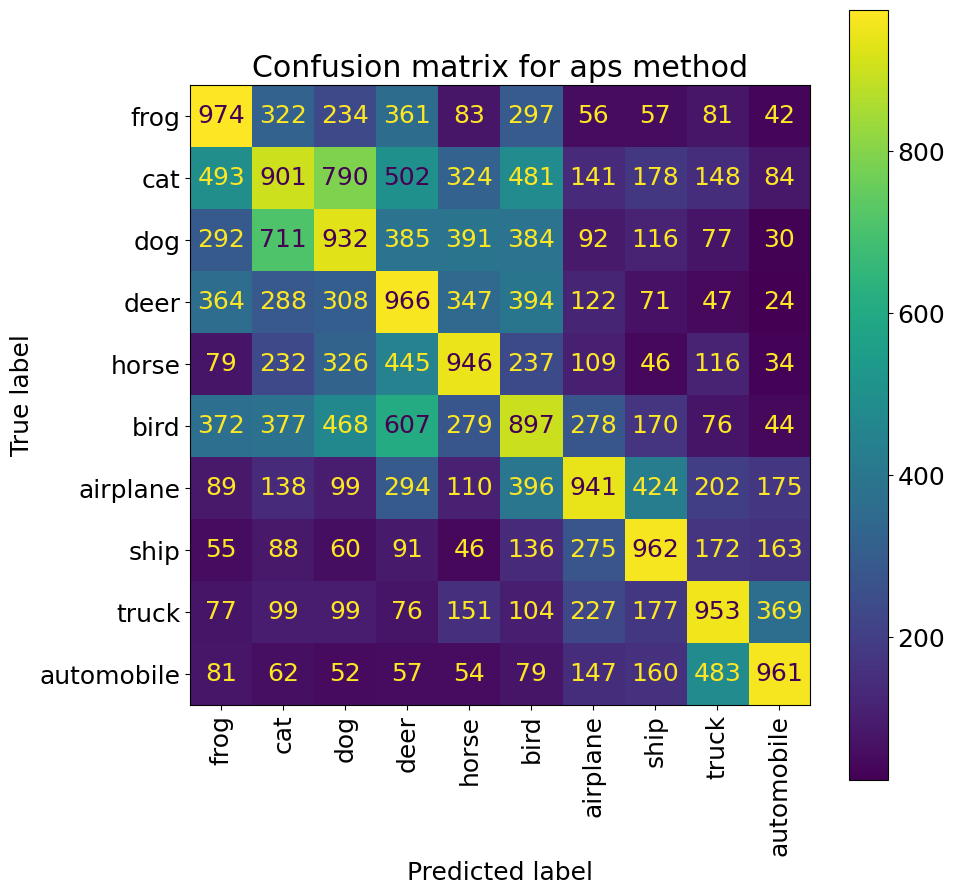

In [37]:
plot_confusion_matrix("aps", y_ps_90, label_names)

Thanks to this confusion matrix we can see that, for some labels (as cat, deer, dog and bird) the distribution of the labels in the prediction set is not uniform. Indeed, when the image is a cat, there are almost as many predictions sets with the true label as with the "dog" label. In this case, the reverse is also true. However, for the deer, the bird label is often included within the prediction set, compared to the deer when the image is a bird.